In [17]:
%matplotlib inline

In [19]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import datetime
import requests
from pandas.io.json import json_normalize
import webbrowser
import sqlite3
import pandas as pd
import collections
import far2cel



# URL format for the API request
# https://api.forecast.io/forecast/APIKEY/LATITUDE,LONGITUDE,TIME

# Defining fucntion that converts Fahrenheit to Celsius degree as I work in Celisus degree
def far2cel(far):
    #Converting Fahrenheit to Celsius
    cel=(far - 32) / 1.8
    return cel

### Challenge

1) Build the API call by combining the string elements in Python for your first city

In [29]:
# dictionariy of cities
citta = {"Lugano": '46.0030,8.9513',
         "Lausanne": '46.5196,6.6322',
         "Roma": '41.9031,12.4958',
         "Quebec": '46.8221,-71.2231',
         "Ottawa": '45.4594,-75.5184',
         "Vancouver": '49.2604,-123.1133'}

# Lugano : Switzerland
# Lausanne : Switzerland
# Rome : Italy
# Quebec : East Canada
# Ottawa : East Canada
# Vancouver : Ouest Canada

# my API key for foricast.io
API_key = 'bd65082df114cd750f5541445ec7710f'

# base url for the API call
base_url = 'https://api.forecast.io/forecast/'

# SPRING and FALL start time and date in UNIX format
now_spring = datetime.date(2015, 5, 17)
now_fall = datetime.date(2014, 10, 17)

2) Test the call for your first city and make sure you have it formatted properly

In [30]:
# API call for the first city
API_call = base_url + API_key + '/' + citta["Lugano"] + ',' + now_spring.strftime('%s')

# Open the API call in the broweser
webbrowser.open_new(API_call)

True

3a) Once you have the URL formatted properly, issue the request from your code and inspect the result. How many levels does the data have? 

In [31]:
r = requests.get(API_call)

# To check how many levels we have in the data below the root level
print 'The level below the root in the API call are {0}'.format(len(r.json().keys()))

The level below the root in the API call are 8


3b) Which field do we want to save to get the daily maximum temperature?


In [32]:
# The field daily has a keys data and a values that is a list of dictionary
daily = r.json()['daily']['data']

# The list of dictionary contains a keys 'temperatureMax'
for x in daily:
    t_max = far2cel(x["temperatureMax"])
    print t_max

26.0666666667


4-5) Based on the data sample, create the table in a SQLite database called "weather.db". Based on the data sample, create the table in a SQLite database called "weather.db".

In [7]:
# create and connect to a database
conn = sqlite3.connect('weather.db')

# All interactions with the database are called querys
# And they require to be used through a cursor
c = conn.cursor()

# The queries are applied using the .execute() method
c.execute('DROP TABLE IF EXISTS citta')

# Create a new table called citta (cities in italian) 
c.execute('''CREATE TABLE citta (city_name text, lat_lon float)''')

# Insert the values of citta into the tables
c.executemany("INSERT INTO citta VALUES (?, ?)", citta.items())

# Save (commit) the changes to the database
conn.commit() 

5-6) Write a script that takes each city and queries every day for the past 60 days (more interesting) in spring and save the avg temperature values to the table, keyed on the date. I will do the same with fall time and compare the results.

In [8]:
# The queries are applied using the .execute() method
# Delete existing table
c.execute('DROP TABLE IF EXISTS daily_avg_spring')
c.execute('DROP TABLE IF EXISTS daily_avg_fall')

# create a new tables to store daily_avg temperature for each citta in SPRING and FALL
c.execute('CREATE TABLE daily_avg_spring (date int, Lugano float, Lausanne float, Roma float, Quebec float, Ottawa float, Vancouver float)''')
c.execute('CREATE TABLE daily_avg_fall (date int, Lugano float, Lausanne float, Roma float, Quebec float, Ottawa float, Vancouver float)''')

# Retrieve data from sql database
df = pd.read_sql_query('SELECT * FROM citta',conn)

# Latitude et Longitude to list
geo = df['lat_lon'].tolist()

# Set the strting date of measurmeents (60 days before now_spring) for SPRING and FALL
date_spring = now_spring - datetime.timedelta(days=60)
date_fall = now_fall - datetime.timedelta(days=60)

################# Insert date into the SPRING daily_avg table ##########################
########################################################################################
with conn:
    while date_spring <= now_spring:
        c.execute('INSERT INTO daily_avg_spring(date) VALUES (?)', (int(date_spring.strftime('%s')),))
        date_spring += datetime.timedelta(days=1)
    
for k,v in citta.iteritems():
    date_spring = now_spring - datetime.timedelta(days=60)
    while date_spring <= now_spring:
        API = base_url + API_key + '/' + v + ',' + date_spring.strftime('%s')
        s = requests.get(API)
            
        daily = s.json()['daily']['data']
        # The list of dictionary contains a keys 'temperatureMax'
        for x in daily:
            t_max = far2cel(x["temperatureMax"])
        with conn:
            #insert the temperature max to the database
            c.execute('UPDATE daily_avg_spring SET ' + k + ' = ' + str(round(t_max,1)) + ' WHERE date = ' + date_spring.strftime('%s'))
                
        date_spring += datetime.timedelta(days=1)  

################# Insert date into the FALL daily_avg table ##########################
########################################################################################
with conn:
    while date_fall <= now_fall:
        c.execute('INSERT INTO daily_avg_fall(date) VALUES (?)', (int(date_fall.strftime('%s')),))
        date_fall += datetime.timedelta(days=1)
    
for k,v in citta.iteritems():
    date_fall = now_fall - datetime.timedelta(days=60)
    while date_fall <= now_fall:
        API = base_url + API_key + '/' + v + ',' + date_fall.strftime('%s')
        f = requests.get(API)
            
        daily = f.json()['daily']['data']
        # The list of dictionary contains a keys 'temperatureMax'
        for x in daily:
            t_max = far2cel(x["temperatureMax"])
        with conn:
            #insert the temperature max to the database
            c.execute('UPDATE daily_avg_fall SET ' + k + ' = ' + str(round(t_max,1)) + ' WHERE date = ' + date_fall.strftime('%s'))
                
        date_fall += datetime.timedelta(days=1)

conn.commit()
conn.close()        

What's the range of temperatures for each city? What is the mean temperature for each city? What's the variance? Are there any patterns in the data? Which cities had the largest temperature changes over the time period?

In [9]:
# create and connect to a database
conn = sqlite3.connect('weather.db')
# All interactions with the database are called querys
# And they require to be used through a cursor
c = conn.cursor()
# Retrieve data from sql database for SPRING and FALL
df_spring = pd.read_sql_query('SELECT * FROM daily_avg_spring',conn)
df_fall = pd.read_sql_query('SELECT * FROM daily_avg_fall',conn)

# Drop column date as I'm not interested in its stats
df_spring.drop('date', axis=1, inplace=True)
df_fall.drop('date', axis=1, inplace=True)

In [10]:
##################  Compute basics stats for both dataframes ################# 
##############################################################################

# Spring

rge_s = {}
mean_s = {}
var_s = {}

for key in df_spring.keys():
    # compute the stats
    rge_s[key] = df_spring[key].max()-df_spring[key].min()
    mean_s[key] = df_spring[key].mean()
    var_s[key] = df_spring[key].var()
    
for key,val in rge_s.items():
    print 'The range temperature in Spring for' ,key,  'is'  ,val
for key,val in mean_s.items():
    print 'The mean temperature in Spring for' ,key,  'is'  ,round(val,1)
for key,val in mean_s.items():
    print 'The temperature  variance in Spring for' ,key,  'is'  ,round(val,1)
    
# Fall

rge_f = {}
mean_f = {}
var_f = {}

for key in df_fall.keys():
    # compute the stats
    rge_f[key] = df_fall[key].max()-df_fall[key].min()
    mean_f[key] = df_fall[key].mean()
    var_f[key] = df_fall[key].std()
    
for key,val in rge_f.items():
    print 'The range temperature in Fall for' ,key,  'is'  ,val
for key,val in mean_f.items():
    print 'The mean temperature in Fall for' ,key,  'is'  ,round(val,1)
for key,val in mean_f.items():
    print 'The temperature  variance in Fall for' ,key,  'is'  ,round(val,1)

The range temperature in Spring for Lugano is 18.6
The range temperature in Spring for Ottawa is 37.8
The range temperature in Spring for Lausanne is 18.2
The range temperature in Spring for Vancouver is 11.5
The range temperature in Spring for Quebec is 37.1
The range temperature in Spring for Roma is 20.4
The mean temperature in Spring for Lugano is 18.4
The mean temperature in Spring for Ottawa is 11.9
The mean temperature in Spring for Lausanne is 14.8
The mean temperature in Spring for Vancouver is 13.4
The mean temperature in Spring for Quebec is 8.6
The mean temperature in Spring for Roma is 20.7
The temperature  variance in Spring for Lugano is 18.4
The temperature  variance in Spring for Ottawa is 11.9
The temperature  variance in Spring for Lausanne is 14.8
The temperature  variance in Spring for Vancouver is 13.4
The temperature  variance in Spring for Quebec is 8.6
The temperature  variance in Spring for Roma is 20.7
The range temperature in Fall for Lugano is 14.7
The rang

Find the greatest range in avg temperatures in the months you measured for Spring and Fall time. Which city had the greatest variation? 

In [11]:
# intiate dict of monthly temperature change for spring and fall
monthly_change_spring = collections.defaultdict(int)
monthly_change_fall = collections.defaultdict(int)

# iterate over df_spring.columns
for col in df_spring.columns:
    # put the dataframe of [col] in a list
    temp_val = df_spring[col].tolist()
    # initial values for temperature change
    temp_change = 0
    # iterate over col list using enumerate. Using enumerate we obtain a 
    # a key index (k) for each value of the list
    for k,v in enumerate(temp_val):
        if k < len(temp_val) -1:
            # update temp_change adding the difference between k+1 and k
            temp_change += abs(temp_val[k] - temp_val[k+1])
            # assign the value to the monthly_change dictionary
            monthly_change_spring[col] = temp_change    
            
# iterate over df_fall.columns
for col in df_fall.columns:
    # put the dataframe of [col] in a list
    temp_val = df_fall[col].tolist()
    # initial values for temperature change
    temp_change = 0
    # iterate over col list using enumerate. Using enumerate we obtain a 
    # a key index (k) for each value of the list
    for k,v in enumerate(temp_val):
        if k < len(temp_val) -1:
            # update temp_change adding the difference between k+1 and k
            temp_change += abs(temp_val[k] - temp_val[k+1])
            # assign the value to the monthly_change dictionary
            monthly_change_fall[col] = temp_change  
    

And the winner is? 

In [12]:
max_variation_spring = max(monthly_change_spring, key=monthly_change_spring.get)
max_variation_fall = max(monthly_change_fall, key=monthly_change_fall.get)

print 'The city with the greater temeprature variation in Spring is ' + max_variation_spring
print 'The city with the greater temeprature variation in Fall is ' + max_variation_fall

The city with the greater temeprature variation in Spring is Quebec
The city with the greater temeprature variation in Fall is Ottawa


What is the distribution of the difference? Does the result surprise you?

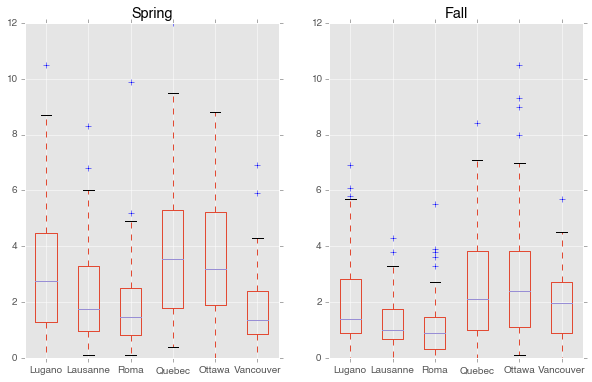

In [21]:
# Create an empty dataframe called monthly_temp_change to store the daily difference for 
# Spring and Fall
columns = df_spring.columns.tolist()
daily_temp_diff_spring=pd.DataFrame(data=np.zeros((0,len(columns))), columns=columns)
daily_temp_diff_fall=pd.DataFrame(data=np.zeros((0,len(columns))), columns=columns)

# Spring
# iterate over df.columns
for col in df_spring.columns:
    # put the dataframe of [col] in a list
    temp_val = df_spring[col].tolist()
    temp_diff = [abs(temp_val[n]-temp_val[n-1]) for n in range(1,len(temp_val))]
    # Populate the dataframe with temp_diff relatives to col
    daily_temp_diff_spring[col] = temp_diff 
    
# Fall
# iterate over df.columns
for col in df_fall.columns:
    # put the dataframe of [col] in a list
    temp_val = df_fall[col].tolist()
    temp_diff = [abs(temp_val[n]-temp_val[n-1]) for n in range(1,len(temp_val))]
    # Populate the dataframe with temp_diff relatives to col
    daily_temp_diff_fall[col] = temp_diff

# Subplot the histograms for each cities for spring and fall
# daily_temp_diff_spring.plot(kind='hist',color='red',subplots=True,figsize=(6,6),bins=10)
# daily_temp_diff_fall.plot(kind='hist',color='blue',subplots=True,figsize=(6,6),bins=10)

# Boxplots for each cities for spring and fall
fig, (ax1,ax2) = plt.subplots(1, 2,figsize=(10,6))
daily_temp_diff_spring.plot(kind='box',title='Spring',ax=ax1,)
daily_temp_diff_fall.plot(kind='box',title='Fall',ax=ax2)

### Spring data analysis

The distributions is similar for Lugano, Lausanne Roma and Vancouver, with the mean value
around two. However, for Quebec and Ottawa, the mean daily difference is slightly high,
meaning there is a greater gap between daily temp. This two cities shows also a greater variability
in daily temperature

### Fall data analysis

In Fall, the daily mean difference value for Quebec and Ottawa is in the same range than 
the other cities. However they still show graeter variability compared to the other cities.

### Final conclusion

We have more chance to have a 'hot' day followed by a 'chill' day in Ottawa, than in Lausanne even though they are at the same latitutde.